In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import urbanpy as up
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

In [3]:
gdf_celdas = gpd.read_parquet("outputs/celdas_country_bra.parquet")
print(f"{gdf_celdas.shape[0]} Cells loaded")

16927 Cells loaded


In [4]:
gdf_schools = gpd.read_parquet(
    "/Users/claudio/Documents/amazonia-bid/outputs/complete_schools.parquet"
)
print(f"{gdf_schools.shape[0]} Cells loaded")

260990 Cells loaded


In [5]:
gdf_schools.loc[:, "lat"] = gdf_schools["geometry"].y
gdf_schools.loc[:, "lon"] = gdf_schools["geometry"].x

In [6]:
gdf_celdas.head()

,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,pop_2010,pop_2015,pop_2020,polygon_id,geometry,code
0,10990,rural,33.774789,73.684276,122.963361,182.253686,255.843079,375.113321,516.263954,677.330003,879.217327,1111.535984,01462-1-1,"POLYGON ((-73.44861 -7.43248, -73.44778 -7.424...",bra
1,11340,rural,40.787618,86.003471,143.616033,213.308203,315.076869,454.252589,625.666751,836.486416,1082.978362,1373.692004,08474-1-1,"POLYGON ((-73.21709 -7.42437, -73.21626 -7.416...",bra
2,11420,rural,66.769884,137.195748,217.874020,308.875040,413.820839,538.151761,692.404688,878.608410,1092.628024,1335.862086,06882-1-1,"POLYGON ((-72.97373 -5.73784, -72.97309 -5.729...",bra
3,11429,rural,57.325188,119.504881,191.428826,272.743450,365.787873,475.210036,610.950871,774.780301,960.037407,1155.258607,06882-1-1,"POLYGON ((-72.96436 -5.74594, -72.96372 -5.737...",bra
4,11531,rural,27.586158,60.270482,105.306524,166.063003,236.071840,316.338729,413.987196,529.341950,673.569333,896.167356,07155-1-1,"POLYGON ((-72.99814 -7.53797, -72.99729 -7.529...",bra


In [7]:
gdf_celdas["code"].value_counts()

code
bra    16927
Name: count, dtype: int64

In [8]:
gdf_celdas["code"].isna().sum()

np.int64(0)

In [9]:
gdf_schools["Pais"].value_counts()

Pais
Brasil       222936
Perú          22093
Bolivia        8209
Ecuador        3458
Colombia       2805
Venezuela       680
Guyana          466
Suriname        343
Name: count, dtype: int64

In [10]:
gdf_schools_bra = gdf_schools[gdf_schools["Pais"] == "Brasil"]

In [11]:
gdf_schools_bra.shape

(222936, 7)

In [12]:
assert gdf_schools.crs.to_string() == gdf_celdas.crs.to_string(), "CRS do not match"

In [13]:
brazil_subregions_polys = gpd.read_file(
    "/Users/claudio/Downloads/regions_brazil.geojson"
)
brazil_subregions_polys

,name,geometry
0,Sul,"POLYGON ((-53.07251 -33.96693, -53.16284 -33.8..."
1,Sudeste,"POLYGON ((-29.00059 -22.95946, -32.63539 -25.0..."
2,Norte,"POLYGON ((-60.69401 -13.73407, -61.01532 -13.5..."
3,Nordeste,"POLYGON ((-29.3325 2.33596, -28.72472 2.03155,..."
4,Centro-oeste,"POLYGON ((-54.35224 -24.18381, -54.36001 -24.1..."


In [14]:
brazil_subregions_polys.crs.to_string()

'EPSG:4326'

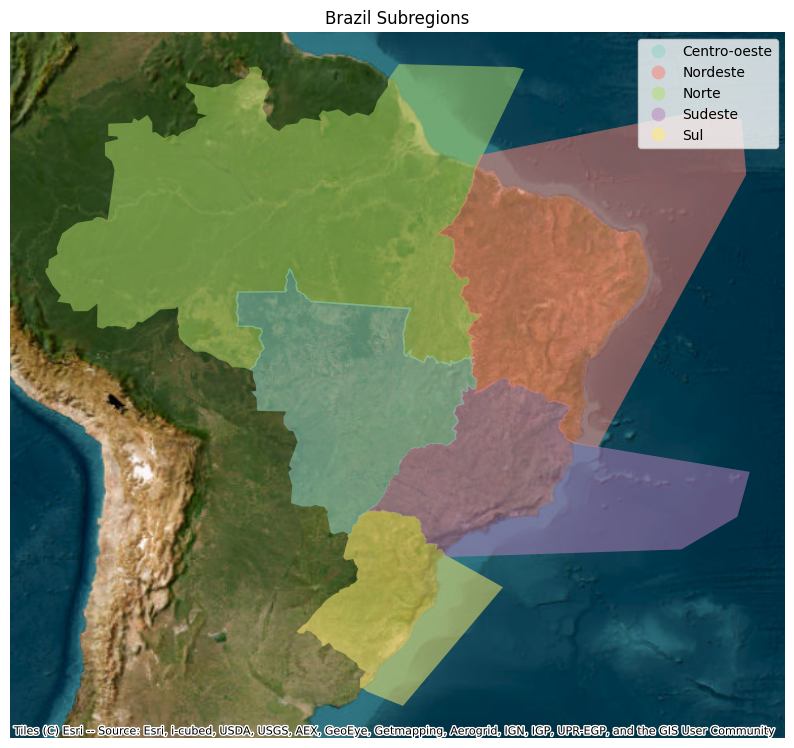

In [15]:
# Check the boundaries with a plot
fig, ax = plt.subplots(figsize=(10, 10))

brazil_subregions_polys.plot("name", cmap="Set3", legend=True, ax=ax, alpha=0.5)

ctx.add_basemap(
    ax, source=ctx.providers.Esri.WorldImagery, crs=brazil_subregions_polys.crs
)

ax.set_axis_off()

ax.set_title("Brazil Subregions")

plt.show()

In [16]:
brazil_subregions_polys.shape

(5, 2)

In [17]:
gdf_schools_bra_subregions = (
    gdf_schools_bra.sjoin(
        brazil_subregions_polys,
        how="left",
        predicate="intersects",
    )
    .drop(columns=["index_right"])
    .reset_index()
    .drop_duplicates(subset="index", keep="last")
    .rename(columns={"name": "subregion"})
)

In [19]:
gdf_schools_bra.shape[0], gdf_schools_bra_subregions.shape[0]

(222936, 222936)

In [20]:
print(
    "Schools by subregion\n",
    gdf_schools_bra_subregions["subregion"].value_counts().sort_index(),
)

Schools by subregion
 subregion
Centro-oeste     8395
Nordeste        48278
Norte           17248
Sudeste         57159
Sul             22070
Name: count, dtype: int64


In [21]:
gdf_celdas_subregions = (
    gdf_celdas.sjoin(
        brazil_subregions_polys,
        how="left",
        predicate="intersects",
    )
    .reset_index()
    .drop_duplicates(subset="index", keep="last")
    .drop(columns=["index_right"])
    .rename(columns={"name": "subregion"})
)

In [22]:
gdf_celdas.shape[0], gdf_celdas_subregions.shape[0]

(16927, 16927)

In [23]:
print(
    "Cells by subregion\n",
    gdf_celdas_subregions["subregion"].value_counts().sort_index(),
)

Cells by subregion
 subregion
Centro-oeste     2999
Nordeste         3886
Norte           10042
Name: count, dtype: int64


In [24]:
gdf_celdas_subregions["subregion"].isna().sum()

np.int64(0)

In [25]:
assert brazil_subregions_polys.crs.to_string() == gdf_celdas_subregions.crs.to_string()

In [26]:
gdf_schools_bra_norte = gdf_schools_bra_subregions[
    gdf_schools_bra_subregions["subregion"] == "Norte"
].copy()

In [27]:
gdf_celdas_bra_norte = gdf_celdas_subregions[
    gdf_celdas_subregions["subregion"] == "Norte"
].copy()

In [ ]:
gdf_primary_schools_bra_norte = gdf_schools_bra_norte[
    gdf_schools_bra_norte["EduNivelPrimaria"] == 1
]
gdf_secondary_schools_bra_norte = gdf_schools_bra_norte[
    gdf_schools_bra_norte["EduNivelSecundariaTotal"] == 1
]

In [30]:
print("total # of schools in bra norte", gdf_schools_bra_norte.shape[0])
print("primary:", gdf_primary_schools_bra_norte.shape[0])
print("secondary:", gdf_secondary_schools_bra_norte.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_bra_norte.shape[0] + gdf_secondary_schools_bra_norte.shape[0],
)

total # of schools in bra norte 17248
primary: 11429
secondary: 7442
add primary and secondary: 18871


In [31]:
# start server
up.routing.start_osrm_server("south-america/brazil/norte", "foot")

Server is already running.


In [32]:
gdf_celdas_bra_norte_access_primary = up.accessibility.travel_times(
    gdf_celdas_bra_norte, gdf_primary_schools_bra_norte, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/10042 [00:00<?, ?it/s]

In [33]:
# Obtain the school unique_id and lat_lon
gdf_celdas_bra_norte_access_primary = pd.merge(
    gdf_celdas_bra_norte_access_primary,
    gdf_primary_schools_bra_norte.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [ ]:
gdf_celdas_bra_norte_access_total = up.accessibility.travel_times(
    gdf_celdas_bra_norte_access_primary,
    gdf_secondary_schools_bra_norte,
    "secondary_schools",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/10042 [00:00<?, ?it/s]

In [35]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_bra_norte_access_total = pd.merge(
    gdf_celdas_bra_norte_access_total,
    gdf_secondary_schools_bra_norte.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [ ]:
# Save the results
gdf_celdas_bra_norte_access_total.to_parquet("outputs/celdas_ecu_access_v2.parquet")

In [37]:
up.routing.stop_osrm_server("south-america/brazil/norte", "foot")

Server was stoped succesfully


### Nordeste


Select the data for the subregion


In [ ]:
gdf_celdas_bra_nordeste = gdf_celdas_subregions[
    gdf_celdas_subregions["subregion"] == "Nordeste"
].copy()
print("# of cells in Nordest:", gdf_celdas_bra_nordeste.shape[0])

# of cells in Nordest: 3886


In [38]:
gdf_schools_bra_nordeste = gdf_schools_bra_subregions[
    gdf_schools_bra_subregions["subregion"] == "Nordeste"
].copy()
print("# of schools in Nordest:", gdf_schools_bra_nordeste.shape[0])

# of schools in Nordest: 48278


In [ ]:
gdf_primary_schools_bra_nordeste = gdf_schools_bra_nordeste[
    gdf_schools_bra_nordeste["EduNivelPrimaria"] == 1
]
gdf_secondary_schools_bra_nordeste = gdf_schools_bra_nordeste[
    gdf_schools_bra_nordeste["EduNivelSecundariaTotal"] == 1
]

In [ ]:
print("total # of schools in bra norte", gdf_schools_bra_nordeste.shape[0])
print("primary:", gdf_primary_schools_bra_nordeste.shape[0])
print("secondary:", gdf_secondary_schools_bra_nordeste.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_bra_nordeste.shape[0]
    + gdf_secondary_schools_bra_nordeste.shape[0],
)

total # of schools in bra norte 48278
primary: 28990
secondary: 18688
add primary and secondary: 47678


In [43]:
# start server
up.routing.start_osrm_server("south-america/brazil/nordeste", "foot")

Server is already running.


In [44]:
gdf_celdas_bra_nordeste_access_primary = up.accessibility.travel_times(
    gdf_celdas_bra_nordeste, gdf_primary_schools_bra_nordeste, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/3886 [00:00<?, ?it/s]

In [46]:
# Obtain the school unique_id and lat_lon
gdf_celdas_bra_nordeste_access_primary = pd.merge(
    gdf_celdas_bra_nordeste_access_primary,
    gdf_primary_schools_bra_nordeste.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [ ]:
gdf_celdas_bra_nordeste_access_total = up.accessibility.travel_times(
    gdf_celdas_bra_nordeste_access_primary,
    gdf_secondary_schools_bra_nordeste,
    "secondary_schools",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/3886 [00:00<?, ?it/s]

In [48]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_bra_nordeste_access_total = pd.merge(
    gdf_celdas_bra_nordeste_access_total,
    gdf_secondary_schools_bra_nordeste.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [ ]:
# Save the results
gdf_celdas_bra_nordeste_access_total.to_parquet(
    "outputs/celdas_bra_nordeste_access_v2.parquet"
)

In [57]:
up.routing.stop_osrm_server("south-america/brazil/nordeste", "foot")

Server was stoped succesfully


### Centro-Oeste


In [52]:
gdf_celdas_bra_centro_oeste = gdf_celdas_subregions[
    gdf_celdas_subregions["subregion"] == "Centro-oeste"
].copy()
print("# of cells in Centro-oeste:", gdf_celdas_bra_centro_oeste.shape[0])

# of cells in Centro-oeste: 2999


In [51]:
gdf_schools_bra_centro_oeste = gdf_schools_bra_subregions[
    gdf_schools_bra_subregions["subregion"] == "Centro-oeste"
].copy()
print("# of schools in Centro-oeste:", gdf_schools_bra_centro_oeste.shape[0])

# of schools in Centro-oeste: 8395


In [ ]:
gdf_primary_schools_bra_centro_oeste = gdf_schools_bra_centro_oeste[
    gdf_schools_bra_centro_oeste["EduNivelPrimaria"] == 1
]
gdf_secondary_schools_bra_centro_oeste = gdf_schools_bra_centro_oeste[
    gdf_schools_bra_centro_oeste["EduNivelSecundariaTotal"] == 1
]

In [ ]:
print("schools without edu level - probably closed")
gdf_schools_bra_centro_oeste[
    (gdf_schools_bra_centro_oeste["EduNivelPrimaria"] == 0)
    & (gdf_schools_bra_centro_oeste["EduNivelSecundariaTotal"] == 0)
].shape[0]

schools without edu level - probably closed


2522

In [ ]:
print("total # of schools in bra norte", gdf_schools_bra_centro_oeste.shape[0])
print("primary:", gdf_primary_schools_bra_centro_oeste.shape[0])
print("secondary:", gdf_secondary_schools_bra_centro_oeste.shape[0])
print(
    "add primary and secondary:",
    gdf_primary_schools_bra_centro_oeste.shape[0]
    + gdf_secondary_schools_bra_centro_oeste.shape[0],
)

total # of schools in bra norte 8395
primary: 4202
secondary: 3703
add primary and secondary: 7905


In [58]:
# start server
up.routing.start_osrm_server("south-america/brazil/centro-oeste", "foot")

Starting server ...
osrm_routing_server_south-america_brazil_centro-oeste_foot
Server was started succesfully


In [68]:
gdf_celdas_bra_centro_oeste_access_primary = up.accessibility.travel_times(
    gdf_celdas_bra_centro_oeste, gdf_primary_schools_bra_centro_oeste, "primary_schools"
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/2999 [00:00<?, ?it/s]

In [69]:
# Obtain the school unique_id and lat_lon
gdf_celdas_bra_centro_oeste_access_primary = pd.merge(
    gdf_celdas_bra_centro_oeste_access_primary,
    gdf_primary_schools_bra_centro_oeste.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_primary_schools_ix",
    right_index=True,
    suffixes=("", "_primary_school"),
)

In [ ]:
gdf_celdas_bra_centro_oeste_access_total = up.accessibility.travel_times(
    gdf_celdas_bra_centro_oeste_access_primary,
    gdf_secondary_schools_bra_centro_oeste,
    "secondary_schools",
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/2999 [00:00<?, ?it/s]

In [72]:
# Obtain the secondary school unique_id and lat_lon
gdf_celdas_bra_centro_oeste_access_total = pd.merge(
    gdf_celdas_bra_centro_oeste_access_total,
    gdf_secondary_schools_bra_centro_oeste.reset_index()[["unique_id", "lat", "lon"]],
    how="left",
    left_on="nearest_secondary_schools_ix",
    right_index=True,
    suffixes=("", "_secondary_school"),
)

In [ ]:
# Save the results
gdf_celdas_bra_centro_oeste_access_total.to_parquet(
    "outputs/celdas_bra_centro_oeste_access_v2.parquet"
)

In [74]:
up.routing.stop_osrm_server("south-america/brazil/centro-oeste", "foot")

Server was stoped succesfully


In [75]:
gdf_celdas_bra_centro_oeste_access_total.head()

,index,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
2854,2851,22041,rural,18.765664,39.297001,63.262898,90.669156,146.941962,242.597356,437.040635,...,brasil51089033,-9.929601,-59.91033,1458,134.0617,1608.765000,>120,brasil51089033,-9.929601,-59.91033
2855,2852,22042,rural,411.031586,834.431719,1313.343709,1848.070963,2420.711819,3075.604951,3813.581931,...,brasil51089033,-9.929601,-59.91033,1458,134.3189,1611.851667,>120,brasil51089033,-9.929601,-59.91033
2856,2853,22043,rural,27.183262,77.405147,150.423605,246.934510,392.787094,605.940765,829.532192,...,brasil51089033,-9.929601,-59.91033,1458,135.5667,1626.825000,>120,brasil51089033,-9.929601,-59.91033
3039,3032,22309,rural,133.885885,277.310781,442.758593,630.867168,828.769361,1073.646833,1407.576605,...,brasil51089033,-9.929601,-59.91033,1458,0.9651,11.580000,0-15,brasil51089033,-9.929601,-59.91033
3040,3033,22310,rural,145.822006,302.154041,482.598554,687.845220,861.912532,1077.294146,1384.516991,...,brasil51089033,-9.929601,-59.91033,1458,1.3411,16.093333,15-30,brasil51089033,-9.929601,-59.91033


In [76]:
# def add_education_level(gdf_celdas, gdf_schools):
#     # Perform a merge using the neatest schools index
#     gdf_schools["school_ix"] = range(len(gdf_schools))
#     gdf_schools.set_index("school_ix", inplace=True)
#     gdf_celdas = gdf_celdas.merge(
#         gdf_schools[["EduNivelPrimaria", "EduNivelSecundariaTotal"]],
#         left_on="nearest_schools_ix",
#         right_index=True,
#         how="left",
#     )
#     return gdf_celdas

In [77]:
# # Apply the function for each country
# gdf_celdas_bra_norte_access_comp = add_education_level(
#     gdf_celdas_bra_norte_access, gdf_schools_bra_norte
# )
# gdf_celdas_bra_nordeste_access_comp = add_education_level(
#     gdf_celdas_bra_nordeste_access, gdf_schools_bra_nordeste
# )
# gdf_celdas_bra_centro_oeste_access_comp = add_education_level(
#     gdf_celdas_bra_centro_oeste_access, gdf_schools_bra_centro_oeste
# )

In [78]:
# Read and concatenate them into a single GeoDataFrame
gdf_combined_comp = gpd.GeoDataFrame(
    pd.concat(
        [
            gdf_celdas_bra_norte_access_total,
            gdf_celdas_bra_nordeste_access_total,
            gdf_celdas_bra_centro_oeste_access_total,
        ],
        ignore_index=True,
    )
)

# Display the combined GeoDataFrame
gdf_combined_comp.head()

,index,cell_id,smod,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,pop_2005,...,unique_id,lat_primary_school,lon_primary_school,nearest_secondary_schools_ix,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,unique_id_secondary_school,lat_secondary_school,lon_secondary_school
0,0,10990,rural,33.774789,73.684276,122.963361,182.253686,255.843079,375.113321,516.263954,...,brasil12001821,-7.525277,-73.005554,494,82.5490,990.581667,>120,brasil12001821,-7.525277,-73.005554
1,1,11340,rural,40.787618,86.003471,143.616033,213.308203,315.076869,454.252589,625.666751,...,brasil12001821,-7.525277,-73.005554,494,80.5647,966.770000,>120,brasil12001821,-7.525277,-73.005554
2,2,11420,rural,66.769884,137.195748,217.874020,308.875040,413.820839,538.151761,692.404688,...,brasil12001821,-7.525277,-73.005554,494,133.4141,1600.955000,>120,brasil12001821,-7.525277,-73.005554
3,3,11429,rural,57.325188,119.504881,191.428826,272.743450,365.787873,475.210036,610.950871,...,brasil12001821,-7.525277,-73.005554,494,133.4141,1600.955000,>120,brasil12001821,-7.525277,-73.005554
4,4,11531,rural,27.586158,60.270482,105.306524,166.063003,236.071840,316.338729,413.987196,...,brasil12001821,-7.525277,-73.005554,494,1.0877,13.056667,0-15,brasil12001821,-7.525277,-73.005554


In [79]:
# gdf_combined_comp["nivel_educativo"] = gdf_combined_comp.apply(
#     lambda x: (
#         "Primaria"
#         if x["EduNivelPrimaria"] == 1
#         else "Secundaria" if x["EduNivelSecundariaTotal"] == 1 else "Ninguno"
#     ),
#     axis=1,
# )

In [80]:
# gdf_combined_comp["nivel_educativo"].value_counts()

In [81]:
# Save the combined GeoDataFrame to a new file
gdf_combined_comp.to_parquet("outputs/celdas_combined_bra_access_v2.parquet")